# Question 2: 

## Introduction

## Imports

In [124]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## Initialising the Dataset

Like in the Q1 notebook, we need to load the data in a useable form (i.e. a pandas dataframe).

In [125]:
# change the path to where the csv file is stored on your pc
path = '/Users/ryanu/Documents/Uni/ACT/SDSS-DR14-Classification/SDSS Data.csv'
data = pd.read_csv(path)
#data

I am going to start off using the same features as in Q1.

In [126]:
features = data[['u', 'g', 'r', 'i', 'z']]
labels = data['class']
#features

## Data Preprocessing

Like in Q1 with the decision tree, we need to split the data between training and testing. However, now we're going also split out a validation set. Where the training set is used to train the model, and the testing set is used to measure the models performance, the validation set will be used to tune hyperparameters (e.g., learning rate, architecture) and monitor overfitting during training.

In [127]:
# Split the data into training, verification, and testing sets
    # train_test_split() splits the data into training and testing sets
    # test_size=0.2 specifies that 20% of the data should be used for testing
    # random_state=42 is a random seed used to shuffle the data
    # The data is split into training and validation sets in a 80:20 ratio
    # The training set is then split into training and validation sets in a 80:20 ratio
    # The final data is split into training, validation, and testing sets in a 64:16:20 ratio
features_train_val, features_test, label_train_val, label_test = train_test_split(features, labels, test_size=0.2, random_state=42)
features_train, features_val, label_train, label_val = train_test_split(features_train_val, label_train_val, test_size=0.2, random_state=42)

In order to train a neural network we need to get the data into the right format to work with. The first step is to normalise all the data. Neural networks often perform better with normalised data because they are sensitive to the scale of the input features Standardization ensures that features with larger ranges don’t dominate, and makes the model converge faster.

In [128]:
# Initiliase the StandardScaler() function
    # It's important to initialise the StandardScaler() function, then use it for all the data sets to ensure that the same scaling is applied to all the data sets
    # The StandardScaler() function scales the data so that it has a mean of 0 and a standard deviation of 1
scaler = StandardScaler()

# Fit the StandardScaler() function to the training data
    # The fit_transform() function fits the StandardScaler() function to the training data and then scales the training data
    # The transform() function scales the validation and testing data using the same scaling as the training data
    # This ensures that the validation and testing data are scaled in the same way as the training data
features_train_normalised = scaler.fit_transform(features_train)
features_val_normalised = scaler.transform(features_val)
features_test_normalised = scaler.transform(features_test) 

We then need to convert the label names (Star, Galaxy, QSO) into numbers as neural networks expect numerical inputs and outputs.

In [129]:
# Encode the labels using the LabelEncoder() function
    # Again, it's important to initialise the LabelEncoder() function, then use it for all the data sets to ensure that the same encoding is applied to all the data sets
    # The LabelEncoder() function encodes the labels, in alphabetical order, as integers starting from 0 (e.g. Galaxy is 0, QSO is 1, Star is 2)
    # This is necessary because the labels need to be integers for the model to be able to use them
label_encoder = LabelEncoder()

# Fit the LabelEncoder() function to the training labels
    # The fit_transform() function fits the LabelEncoder() function to the training labels and then encodes the training labels
    # The transform() function encodes the validation and testing labels using the same encoding as the training labels
    # This ensures that the validation and testing labels are encoded in the same way as the training labels
label_train_encoded = label_encoder.fit_transform(label_train)
label_val_encoded = label_encoder.transform(label_val)
label_test_encoded = label_encoder.transform(label_test)

We then want to store the datasets as a PyTorch tensor, which are similar to NumPy arrays but have some unique features that make them more suitable for machine learning tasks.

- Multi-Dimensional Arrays:
    - Tensors can have any number of dimensions, making them versatile for representing various types of data, such as scalars (0D), vectors (1D), matrices (2D), and higher-dimensional arrays
- GPU Acceleration:
    - PyTorch tensors can be moved to and operated on using GPUs, which significantly speeds up computations, especially for large-scale machine learning models
- Automatic Differentiation:
    - PyTorch tensors support automatic differentiation, which is essential for training neural networks. This feature is provided by PyTorch's autograd module, which automatically computes gradients for tensor operations
- Interoperability with NumPy:
    - PyTorch tensors can be easily converted to and from NumPy arrays, allowing seamless integration with existing NumPy-based code

In [130]:
# Convert features and labels into PyTorch tensors
    # torch.tensor() creates a tensor from a NumPy array
    # dtype=torch.float32 and dtype=torch.long specify the data type of the tensor
features_train_tensor = torch.tensor(features_train_normalised, dtype=torch.float32)
features_val_tensor = torch.tensor(features_val_normalised, dtype=torch.float32)
features_test_tensor = torch.tensor(features_test_normalised, dtype=torch.float32)
label_train_tensor = torch.tensor(label_train_encoded, dtype=torch.long)
label_val_tensor = torch.tensor(label_val_encoded, dtype=torch.long)
label_test_tensor = torch.tensor(label_test_encoded, dtype=torch.long)

The final preprocessing we need to complete is to create dataloaders for the train, validation, and test sets.

- Dataset:
    - We wrap both the feature and label tensor for the training, validation, and testing sets together into a Dataset object
    - Treating the tensors as a dataset likes this allows us to make a Dataloader

- Dataloader:
    - Dataloaders provide an efficient way to iterate over a dataset
    - They are designed to handle batching, shuffling, and parallel data loading, making it easier to feed data into a model during training and evaluation
    - Batching divindes the dataset into small subsets that are processed sequentially, which is more efficient than processing them one at a time
    - Shuffling the data introduces randomness and improves the generalisation of the model by ensure the model doesn't just learn the order of the data
    - Parallel data loading speeds the data loading process up by running multiple worker processes at once

In [131]:
# Create a Dataset for the training, validation, and testing sets
    # torch.utils.data.TensorDataset() creates a dataset from the tensors
    # A dataset is a collection of features and labels
    # The dataset is used to create a DataLoader
train_dataset = torch.utils.data.TensorDataset(features_train_tensor, label_train_tensor)
val_dataset = torch.utils.data.TensorDataset(features_val_tensor, label_val_tensor)
test_dataset = torch.utils.data.TensorDataset(features_test_tensor, label_test_tensor)

# Create a DataLoader for the training, validation, and testing sets
    # torch.utils.data.DataLoader() creates a DataLoader from the dataset
    # A DataLoader is an iterable that provides batches of data
    # batch_size=32 specifies that each batch should contain 32 samples, can be finetuned
    # shuffle specifies whether the data should be shuffled or not
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Defining the Neural Network

Now that we have the data ready, we can define the actual neural network (NN). The SimpleNN class defines a Feedforward Neural Network (FNN), which is the simplest type of NN. It's called feedforward because the data flows in one direction; from the input layer, through any hidden layers, into the output layer. There are no loops or cycles in the network.

The first thing the SimpleNN class does it inherit from PyTorch's nn.Module class, which is the base class for all neural network models in PyTorch. This inheritance provides the necessary structure and methods to define and train a neural network.

It then sets up the layers required by the NN.

- The Input Layer:
    - The input layer is the first layer of the NN and has the same number of neurons as the number of input features
    - It isn't explicitly defined in the SimpleNN class because it's just the input data
- First Fully Connected Layer:
    - The first hiddem layer of the NN
    - Tranforms the input data and outputs it to the ReLu activation function
    = Transformation is linear: output = input * weight matrix * bias vector
        - Weight matrix and bias vector are learned during the training
- Rectified Linear Unit (ReLU) Activation Function:
    - The ReLU activation function is applied to the output of the first fully connected layer
    - Introduces non-linearity into the NN by setting any negative inputs to zero
- Second Fully Connected Layer:
    - Takes the output from the ReLU function as an input and performs another linear transformation
- Third Fully Connected Layer:
    - Takes the output from the second layer and outputs to the Log Softmax activation function
- Log Softmax Activation Function:
    - Ensures all inputs are between 0 and 1, and that they sum to 1
    - This ensentially turns computes probabilities

Next it defines the forward() method, which specifies how the data flows through the NN. The forward() method takes the input data as a tensor, then passes it to the first connected layer. The linear output is then passed through the ReLU activation function to help the NN learn complex relationship in the data. The tensor is then passed into the second connected layer, the third, and finally the softmax activation function where log probabilities are calculated. 

In [132]:
class SDSSClassifier(nn.Module):
    '''
    This class defines the neural network model for the classification task. The neural network model consists of three fully connected 
        layers with ReLU activation functions and a softmax activation function at the output layer. The neural network model is defined in
        the __init__() function and the forward pass is defined in the forward() function.
    '''
    def __init__(self, input_size, hidden_size, num_classes):
        '''
        This function initialises the SDSSClassifier class

        :param input_size: The number of input features, e.g. 5 for [u, g, r, i, z]
        :param hidden_size: The number of neurons in the hidden layer
        :param num_classes: The number of output classes, e.g. 3 for [Galaxy, QSO, and Star]
        '''
        # The super() function is used to call the __init__() function of the parent class (nn.Module)
        super(SDSSClassifier, self).__init__()

        # Define the layers of the neural network
            # nn.Linear() defines a fully connected layer
                # The first argument is the number of input neurons
                # The second argument is the number of output neurons
        self.fc1 = nn.Linear(input_size, hidden_size) # First fully connected layer
        self.relu = nn.ReLU() # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Second fully connected layer
        self.fc3 = nn.Linear(hidden_size, num_classes) # Third fully connected layer
        self.softmax = nn.Softmax(dim=1) # Softmax activation function

    def forward(self, input_features):
        '''
        This function defines the forward pass of the neural network model and is called when the neural network model is run. The forward
            pass is the process of inputting the input features into the neural network and obtaining an output.

        :param input_features: The input features
        :return: The output of the neural network (the class probabilities)
        '''
        input_features = self.fc1(input_features) # Pass the input features through the first fully connected layer
        input_features = self.relu(input_features) # Pass the output of the first fully connected layer through the ReLU activation function
        input_features = self.fc2(input_features) # Pass the output of the ReLU activation function through the second fully connected layer
        input_features = self.relu(input_features) # Pass the output of the second fully connected layer through the ReLU activation function
        input_features = self.fc3(input_features) # Pass the output of the ReLU activation function through the third fully connected layer
        return self.softmax(input_features) # Apply the softmax activation function to the output of the third fully connected layer and return the result

Now that the NN has been defined, we can start to initialise it. The input, hidden, and output sizes are defined and then fed into the SimpleNN class to create the model.

In [133]:
# Define the neural network model, loss function, and optimiser
# Input size is the number of input features (e.g., 5 for u, g, r, i, z) we will use
input_size = features_train_tensor.shape[1]

# Hidden size is the number of neurons in the hidden layer
hidden_size = 64  # You can change this value to see how it affects the performance of the model

# Output size is the number of classes (e.g., 3 for star, galaxy, quasar)
    # The number of classes is the number of unique labels in the training data
    # The np.unique() function returns the unique elements in an array, in this case the unique labels in the training data
output_size = len(np.unique(label_train_tensor))

# Create an instance of the SDSSClassifier class
model = SDSSClassifier(input_size, hidden_size, output_size)

## Set up the loss function and optimiser

Next we define the loss function and optimiser.

- Loss function:
    - Used to calculate the error between the predicted output of the neural network and the actual labels
    - A hyperparameter that needs to be tuned to achieve the best performance of the model

- Optmiser:
    - Used to update the weights of the neural network based on the error calculated by the loss function
    - There are many different optimisers available in PyTorch, such as Adam, SGD, RMSprop, etc. We use Adam in this example because it is a popular choice for many tasks, and commonly used for NNs
    - The Adam optimiser is an adaptive learning rate optimiser that adjusts the learning rate during training, which can help the model converge faster and achieve better performance

The loss function and optimiser are defined outside the neural network model class because they are not part of the neural network architecture but are instead used to train the neural network. This also allows them to be easily changed or modified without affecting the neural network architecture.

- Learning rate:
    - The learning rate controls how much the weights of the neural network are updated during training
    - A higher learning rate means the weights are updated more and a smaller learning rate means the weights are updated less, during the training.
    - If the learning rate is too high, the model may converge too quickly or diverge, as it overshoots the minimum of the loss function
    - If the learning rate is too low, the training process can get stuck in a local minimum and/or take a very long time to complete

In [134]:
# Define the loss function
    # nn.CrossEntropyLoss() is the loss function used for classification tasks with multiple classes
    # The CrossEntropyLoss() function combines the softmax activation function and the negative log likelihood loss function
criterion = nn.CrossEntropyLoss()

# Define the optimiser
    # optim.Adam() is the optimiser used to update the weights of the neural network
    # The Adam optimiser is an extension of the stochastic gradient descent optimiser
    # The Adam optimiser adapts the learning rate for each parameter during training
    # The learning rate is specified by the lr argument, which is set to 0.001 (can be finetuned)
    # The model.parameters() function specifies the parameters that need to be updated by the optimiser, which in this case are the weights of the neural network
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [ ]:
# Set number of epochs for training
num_epochs = 20

# Initialize lists to store training and validation loss history
train_loss_history = []
val_loss_history = []

# Train the model for the specified number of epochs
for epoch in range(num_epochs):
    # Enable training mode for the model (some layers may have different behaviour during training and evaluation)
    model.train()

    # Set running loss to 0 for each epoch
    running_loss = 0.0
    
    # Iterate over the training data
    for inputs, labels in train_loader:
        
        # Zero the gradient buffers
            # It's necessary to zero the gradient buffers before the backward pass to prevent gradient accumulation
        optimizer.zero_grad()
        
        # Forward pass
            # The inputs (features) are passed through the model to obtain the outputs
            # The outputs are the class probabilities for each sample
        outputs = model(inputs)
        
        # Compute the loss
            # The loss is computed by comparing the outputs (class probabilities) to the labels (true classes)
        loss = criterion(outputs, labels)
        
        # Backward pass (compute gradients)
            # The backward() function computes the gradients of the loss with respect to the model parameters
            # The gradients are used to update the weights of the model
        loss.backward()
        
        # Update model parameters
            # The step() function updates the weights of the model using the gradients computed in the backward pass
            # The optimizer uses the gradients to update the weights according to the optimisation algorithm (Adam in this case)
        optimizer.step()
        
        # Accumulate loss
            # The loss.item() function returns the loss as a scalar value
            # The loss is accumulated for each batch to calculate the average loss for the epoch
        running_loss += loss.item()
    
    # Calculate average loss for the epoch
        # The average loss is calculated by dividing the accumulated loss by the number of batches
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)


    # Enable evaluation mode for the model
    model.eval()

    # Set validation loss to 0 for each epoch
    val_loss = 0.0

    # Disable gradient calculation during validation
        # It's not necessary to calculate gradients during validation
        # The no_grad() context manager is used to disable gradient calculation
        # Disabling gradient calculation reduces memory consumption and speeds up the computations
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            
            # Forward pass
                # The inputs (features) are passed through the model to obtain the outputs
                # The outputs are the class probabilities for each sample
            outputs = model(inputs)

            # Compute the loss
                # The loss is computed by comparing the outputs (class probabilities) to the labels (true classes)
            loss = criterion(outputs, labels)
            
            # Accumulate loss
                # The loss.item() function returns the loss as a scalar value
                # The loss is accumulated for each batch to calculate the average loss for the epoch
            val_loss += loss.item()
    
    # Calculate average loss for the epoch
        # The average loss is calculated by dividing the accumulated loss by the number of batches
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    # Print training and validation loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/40], Train Loss: 0.8804, Val Loss: 0.7735
Epoch [2/40], Train Loss: 0.7501, Val Loss: 0.7026
Epoch [3/40], Train Loss: 0.6735, Val Loss: 0.6437
Epoch [4/40], Train Loss: 0.6416, Val Loss: 0.6302
Epoch [5/40], Train Loss: 0.6320, Val Loss: 0.6235
Epoch [6/40], Train Loss: 0.6250, Val Loss: 0.6224
Epoch [7/40], Train Loss: 0.6215, Val Loss: 0.6149
Epoch [8/40], Train Loss: 0.6190, Val Loss: 0.6151
Epoch [9/40], Train Loss: 0.6164, Val Loss: 0.6136
Epoch [10/40], Train Loss: 0.6151, Val Loss: 0.6106
Epoch [11/40], Train Loss: 0.6128, Val Loss: 0.6135
Epoch [12/40], Train Loss: 0.6114, Val Loss: 0.6071
Epoch [13/40], Train Loss: 0.6100, Val Loss: 0.6051
Epoch [14/40], Train Loss: 0.6084, Val Loss: 0.6031
Epoch [15/40], Train Loss: 0.6057, Val Loss: 0.6075
Epoch [16/40], Train Loss: 0.6054, Val Loss: 0.6015
Epoch [17/40], Train Loss: 0.6048, Val Loss: 0.5995
Epoch [18/40], Train Loss: 0.6020, Val Loss: 0.5977
Epoch [19/40], Train Loss: 0.6022, Val Loss: 0.5996
Epoch [20/40], Train 

## Plotting the Model

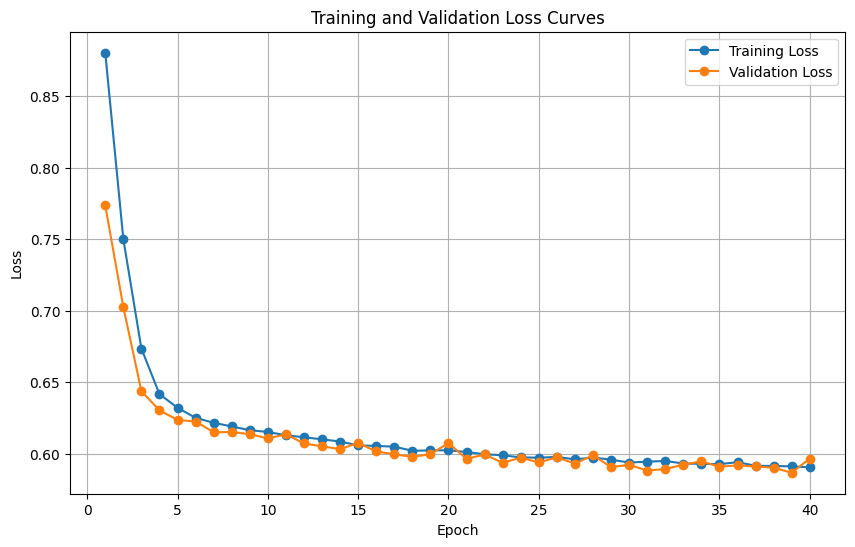

In [148]:
# Plot the training and validation loss curves

# Set the figure size to be 10 inches by 6 inches (width by height), can be adjusted as needed
plt.figure(figsize=(10, 6))

# Plot the training and validation loss curves
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, marker='o', label='Validation Loss')

# Add labels to the x and y axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a title to the plot, display the legend, and show a grid
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()
